In [34]:
import r3.adapters as adapters
import r3.schema as schema
import r3.models.custom_kernels.gp_henderson_hasselbalch_kernel as gp_hh_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    WhiteKernel,
    Matern,
)
from matplotlib import pyplot as plt

# show the r2 score of the predictions
from sklearn.metrics import r2_score

X_columns = [schema.IVTReactionSchema.pH.value, schema.IVTReactionSchema.TIME_min.value]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]

experimental_conditions, responses = adapters.DataPipelineAdapter("ricardo_ph").get_all(
    X_columns=X_columns,
    y_columns=y_columns,
    paths=[["ricardo_ph", "csptris"], ["ricardo_ph", "csphepes"]],
    skip_initial_load=True,
)

X_train = experimental_conditions[1][1].values
y_train = responses[1][1].values

X_test = experimental_conditions[0][1].values
y_test = responses[0][1].values

base_kernel = 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=0.01)
custom_kernel = gp_hh_kernel.HendersonHasselbalchKernel(base_kernel, pKa=7.2)
gp_model = GaussianProcessRegressor(custom_kernel, n_restarts_optimizer=100)

gp_model.fit(X_train, y_train)

adapters.evaluate_model(gp_model, X_train, y_train, X_test, y_test)

📊 Extracted DataFrame with columns ['pH', 'Reaction Time [min]'] and ['RNA [g/L]']


{'train_r2': 0.9860627500620963,
 'test_r2': 0.922427990929715,
 'train_mae': 0.26790441850675195,
 'test_mae': 0.7213452571969433,
 'train_rmse': np.float64(0.4201820021463999),
 'test_rmse': np.float64(1.0880720842344473)}

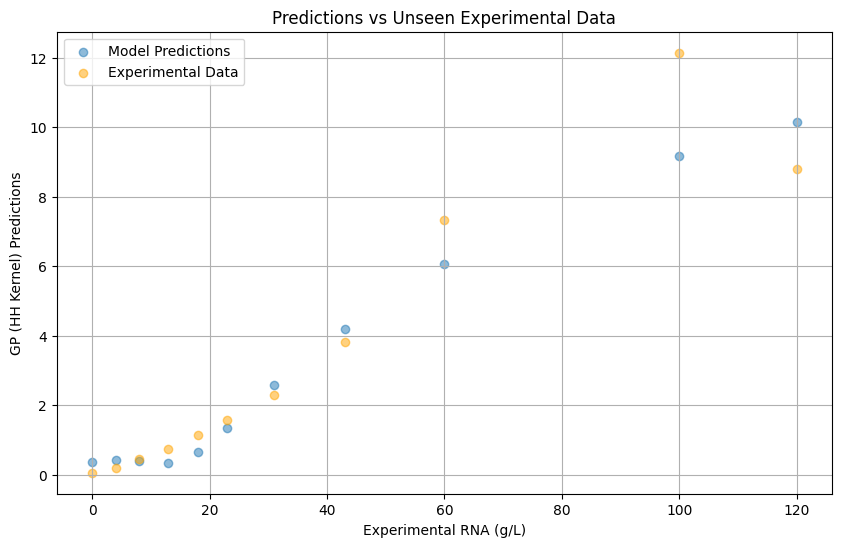

In [35]:
# plot the discrepancy predictions against the experimental data.
predictions = gp_model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(
    X_test[:, 1],  # Reaction Time [min]
    predictions,
    alpha=0.5,
    label="Model Predictions",
)
plt.scatter(
    X_test[:, 1],  # Reaction Time [min]
    y_test,
    color="orange",
    label="Experimental Data",
    alpha=0.5,
)
plt.xlabel("Experimental RNA (g/L)")
plt.ylabel("GP (HH Kernel) Predictions")
plt.title("Predictions vs Unseen Experimental Data")
plt.legend()
plt.grid()
plt.show()